In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Mount Google Drive if needed
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = "/content/drive/MyDrive/Vegetable Images"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Image size and batch size
img_size = (224, 224)
batch_size = 32

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Mounted at /content/drive
Found 12034 images belonging to 15 classes.
Found 3008 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load the MobileNetV2 model (without the top classification layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers (to keep pretrained features)
base_model.trainable = False

# Add a custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling instead of Flatten
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout for regularization
x = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [3]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=18
)

# Save the trained model
model.save('/content/drive/MyDrive/vegetable.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/18
377/377 ━━━━━━━━━━━━━━━━━━━━ 3446s 9s/step - accuracy: 0.8724 - loss: 0.4845 - val_accuracy: 0.9940 - val_loss: 0.0248
Epoch 2/18
377/377 ━━━━━━━━━━━━━━━━━━━━ 767s 2s/step - accuracy: 0.9915 - loss: 0.0339 - val_accuracy: 0.9953 - val_loss: 0.0166
Epoch 3/18
377/377 ━━━━━━━━━━━━━━━━━━━━ 698s 2s/step - accuracy: 0.9950 - loss: 0.0175 - val_accuracy: 0.9983 - val_loss: 0.0102
Epoch 4/18
377/377 ━━━━━━━━━━━━━━━━━━━━ 757s 2s/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9967 - val_loss: 0.0131
Epoch 5/18
377/377 ━━━━━━━━━━━━━━━━━━━━ 725s 2s/step - accuracy: 0.9981 - loss: 0.0092 - val_accuracy: 0.9957 - val_loss: 0.0139
Epoch 6/18
377/377 ━━━━━━━━━━━━━━━━━━━━ 714s 2s/step - accuracy: 0.9975 - loss: 0.0074 - val_accuracy: 0.9973 - val_loss: 0.0129
Epoch 7/18
377/377 ━━━━━━━━━━━━━━━━━━━━ 704s 2s/step - accuracy: 0.9984 - loss: 0.0038 - val_accuracy: 0.9980 - val_loss: 0.0124
Epoch 8/18
377/377 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - accuracy: 0.9989 - loss: 0.0039 - val_acc

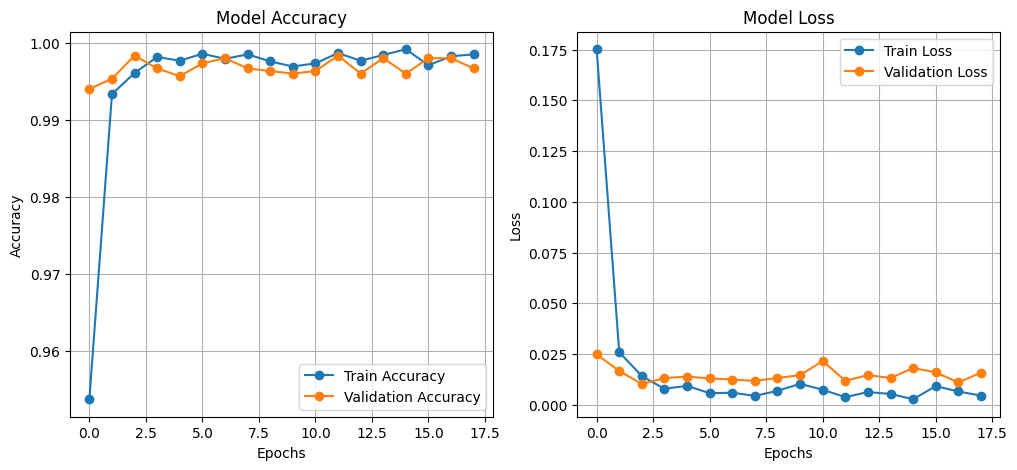

94/94 ━━━━━━━━━━━━━━━━━━━━ 740s 8s/step - accuracy: 0.9974 - loss: 0.0162
Test Accuracy: 99.67%


In [5]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")



In [7]:
import numpy as np
from PIL import Image

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/vegetable.h5')

# Upload an image manually
from google.colab import files
uploaded = files.upload()

# Load and preprocess image
img_path = list(uploaded.keys())[0]
image = Image.open(img_path).resize((224, 224))
img_array = np.expand_dims(np.array(image) / 255.0, axis=0)

# Predict the vegetable
prediction = model.predict(img_array)
class_index = np.argmax(prediction)
class_labels = list(train_generator.class_indices.keys())  # Get class labels from dataset
predicted_class = class_labels[class_index]

print(f"Predicted Vegetable: {predicted_class}")

Saving Brinjal_1.jpg to Brinjal_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Vegetable: Brinjal
